# A short user guide to python tools for visualization and analysis of interferometric data

* ```BaseInterferometry```class is the base class that provides functionality  for analysis of interferometric data.
* Current analysis tools:
    - Fourier transform
    - Wigner-Ville transform
* ```Interferogram``` class is for experimental interferograms.
* ```Simulation``` class is for simulated interferograms.
* Simulations include:
    - Pulse profile
    - Interferogram itself



In [1]:
#import packages
import sys
import glob, os
from parse import parse

# set source path
codepath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry")
if codepath not in sys.path:
    sys.path.append(codepath)

#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

# Experimental interferograms

In [2]:
from Interferometry.classes.interferogram import Interferogram

## Work with a specific dataset in the current directory

## Read and display experimental data

* Initialize an instance of the class by providing all relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Provide the filename to read
    * Set the units of time  and the time step used whilst recording the data


* Read 1D interferometric data by calling the ```read_data()``` method with empty arguments on the instance of the initialized class.              
        
        
* Display the dataset by calling the ```display_temporal_and_ft()```module on the instance of the class. This will automatically compute the 1D Fourier transform of the dataset and display it.

    * Specify the relevant arguments such as the wavelength range to display and the units. 
    * By setting ```vs_wavelength = True ```  one sets the Fourier data to be displayed as a function of wavelength instead of frequency
    * To plot only temporal data, set ```plot_type = temporal```
    * For details call  ```help(ifgm.display_temporal_and_ft)```

In [3]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")
filename = "20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt"
#filename = "20211014scan008-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-6500ns-bias-45v-volt-1k.txt"

ifgm = Interferogram(pathtodata = datapath, 
                     filetoread = filename, 
                     tau_units = "fs", 
                     tau_step = 0.15)

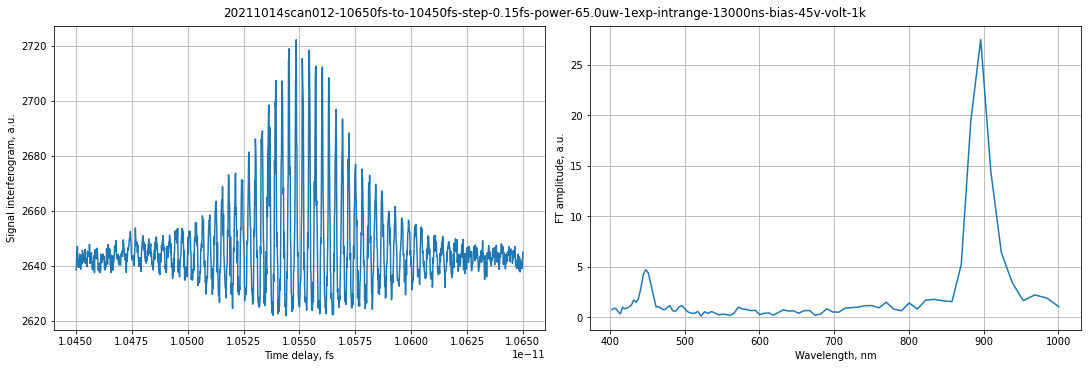

In [4]:
ifgm.display_temporal_and_ft(vs_wavelength=True, 
                             plot_type="both", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

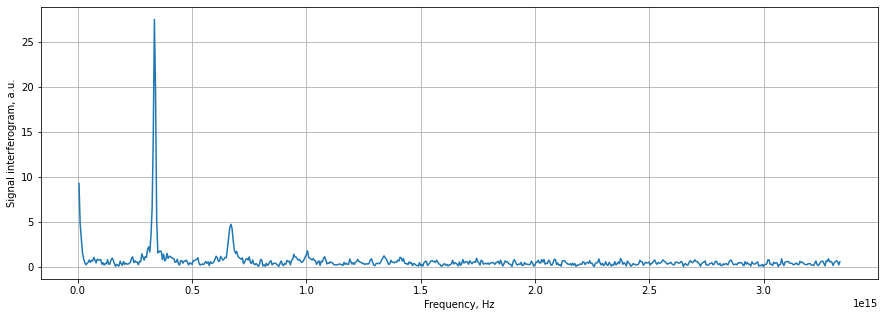

<Figure size 432x288 with 0 Axes>

In [5]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="fourier", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

* If needed, the data can be padded with zero-valued pixels from both sides by ```zero_pad_interferogram``` method of the ```Interferogram``` class.

 ```ifgm.zero_pad_interferogram(pad_width=100e-15)```

## Time-frequency analysis

Calling, ```display_temporal_and_ft```method, computes the Fourier transform of the whole signal. To gain an insight into the local spectral characteritics of the signal as it changes over time, one could use the following methods:

* Short time Fourier transform (STFT) - commonly known as a spectrogram
* Wigner-Ville distribution (WVD)

Local spectral characteristics are important, or example, to analyse  the contributions of different harmonics as the signal changes over time. 



### Normalization


Prior to application of these methods the data are normalised so that the signal values go from 0 to 8 (see more information in the correspondent docstring). These intensity values are the characteristic property of the so-called interferometric autocorrelation (with the baseline at 1). See, for example [Steinmeyer_1999, ULP_Keller] Since we expect our data to be of that autocorrelation type (at least to some extent), we normalize it. 



* In ```normalizing_width```, set the temporal width of the sampled waveform to use for normalization and the position where it starts.

In [7]:
ifgm.normalize_interferogram()

ValueError: starting value start_at cannot be none! 

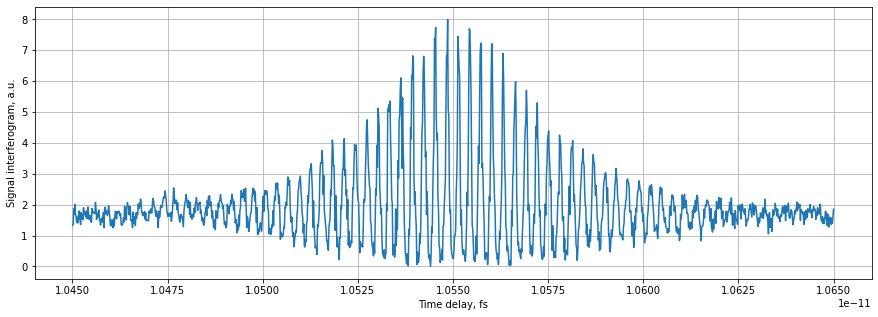

<Figure size 432x288 with 0 Axes>

In [991]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="temporal", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

### Spectrogram

* To compute the spectrogram, call ```compute_spectrogram_of_interferogram```method on the intererogram's class instance.
* ```nperse```sets the window size of the short time Fourier transform
* NOTE: the interferogram data must be normalized!

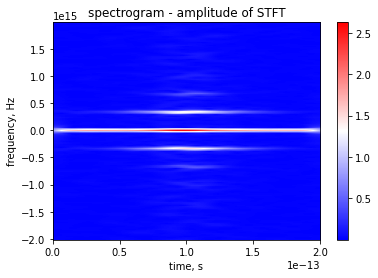

In [970]:
ifgm.compute_stft_spectrogram(nperseg=2**8, plotting=True, zoom_in_freq=2e15)

* The spectrogram contains the 0th, 1st and 2nd harmonic components. Due to the time-frequency uncertainty relation (we use a finite window to compute the FT), the width of the harmonic peaks is only a rough estimate of the physical duration of the  correspondent signals.

### Wigner-Ville transform

* WVT allows to obtain a better temporal resolution than STFT
* Call ```compute_wigner_ville_distribution```method on the intererogram's class instance and specify the parameters. One may need to vary the max and min hue values to avoid clipping.

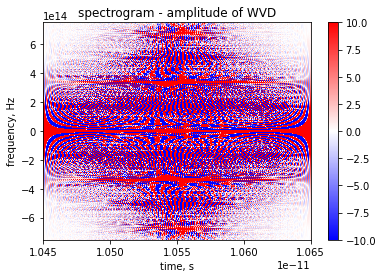

In [855]:
ifgm.compute_wigner_ville_distribution(zoom_in_freq=0.75e15, plotting=True, vmin=-10, vmax=10);

* Just as the STFT, the WVD contains the 0th, 1st and 2nd harmonic components (well pronounced red  features in the figure above).  The red-blue zebra-like features located between the harmonics are WVD's interference artefacts. 


* Computation of the WVD allows to confirm, at the first glance, the existence of the 2nd order correlation signal in the input data.

* Moreover, later, the WVD is used to estimate the temporal duration of the second-order correlation component of the experimental data.

* More info in [Cohen_1999]

## Computation of the second-order correlation function (g2) from experimental data

* from the quick t-f analysis above we see there is some second harmonic signal in the experimental data, which indicates the presence of the interferometric autocorrelation component. The second order coherence function can be extracted by low-pass fitering of the latter.

### g2 by low-pass filtering using default parameters

* Let's try computing  the g2 function by low-pass filtering the raw data. We use Butterworth filter here [Butterworth_1930].  Provide a cutoff frequency and an order of the filter in the ```compute_g2``` method of the Interferogram class.

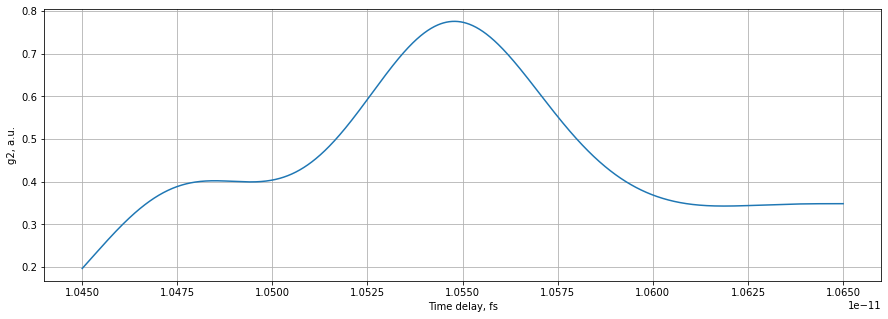

<Figure size 432x288 with 0 Axes>

In [971]:
ifgm.compute_g2(filter_cutoff=15e12, filter_order=3, apply_support=False, plotting=True)

### g2 by low-pass filtering - varying cuttoff frequency and the filter order


* Obviously, by varying the cut-off frequency and the filter order, we change the amplitude value of the resulting g2 function. 
* To plot the distribution of the g2 function vs. different cut-off frequencies and for different filter orders,
use the ```gen_g2_vs_cutoff```method.
* For coherent light, at zero time delay the g2 function is expected to be 1.
* For illustration purposes, one may want to exclude from plotting those g2 functions
whose values at time delay zero are slightly above or below 1 (let's say are below 0.95 and above 1.05). 
* This can be done by setting g2_min and g2_max arguments.

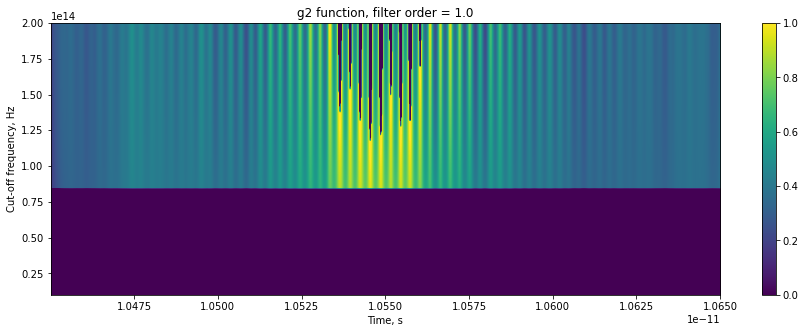

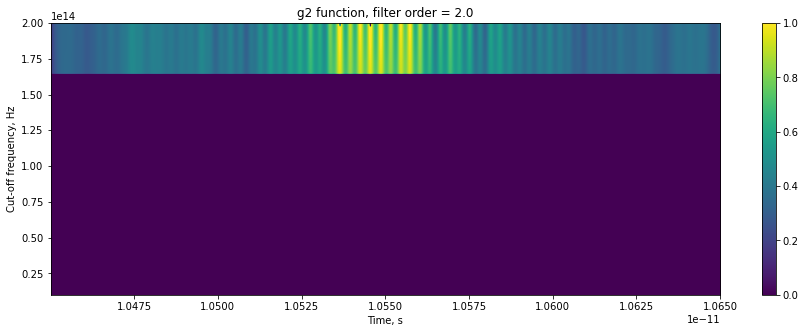

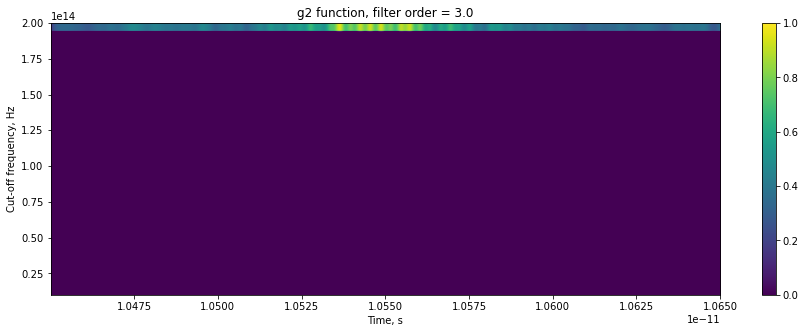

In [977]:
ifgm.compute_g2_vs_lowpass_cutoff(cutoff_min = 10e12, cutoff_max = 200e12, cutoff_step = 2e12,
                              order_min = 1, order_max = 3, order_step = 1,
                              g2_min = 0.95, g2_max = 1.05,
                              to_plot = True);

* There are two aspects to consider: 

* (1) We expect the value of g2 at time delay 0 to be 1. The analysis above suggests its value oscillates  through the delay and is between 0.95 and 1.05 at delay 0 for a range of filtering parameters. We do not expect any oscillations.

* (2) The g2 function plotted above is computed for all samples of the temporal delay. From the physical point of view, the  second order correlation function is defined only for those temporal delays, where the measured autocorrelation is interferometric (i.e. where two photons are absorbed simultaneously).

* While interferometric autocorrelation can be easily simulated for an arbitrary range of temporal delays (set by the laser pulse duration), in experiment it is set both by the pulse duration and the region of the two-photon absorption process.

* The question is how we can estimate the temporal range of the two-photon absorption in the experiment and hence the region where the values of the computed g2 function make physical sense (e.g. the so-called g2 function support).

* One way would be, for example, to threshold the two-photon absorption signal as following. Extract the TPA signal from the Wigner-Ville distribution of the measured interferogram. Given the signal, one needs to decide at what value of the intensity the signal to noise ratio is too low to make any sense to claim the TPA process had happened. To estimate this value, we could, for example, do a simulation. We set the laser pulse duration to a certain value and then extract the intensity value of the TPA signal distribution  from the WVD of the simulation at the set FWHM pulse width.  For pulse duration in the range of interest (50-200 fs), the threshold is roughly the same and amounts to 20% of the maximum value of the TPA signal (see the seciton on Simulation below).  

* This number provides us with a reasonable estimate for the upper-limit of the TPA process and hence for the the g2 function support. 

* The steps below deal with asppect (2), while the later sections address aspect 1.

### Estimation of the g2 function support from the Wigner-Ville transform

* Call ```get_g2_support```method on the intererogram's class instance and specify the parameters. Setting too low ```tpa_tolerance```may lead to unrealistically narrow support. Too high values will lead to an overestimate. Values on the order of the optical cycle seem to be working well. See more info in the docstring of the corresponding method.

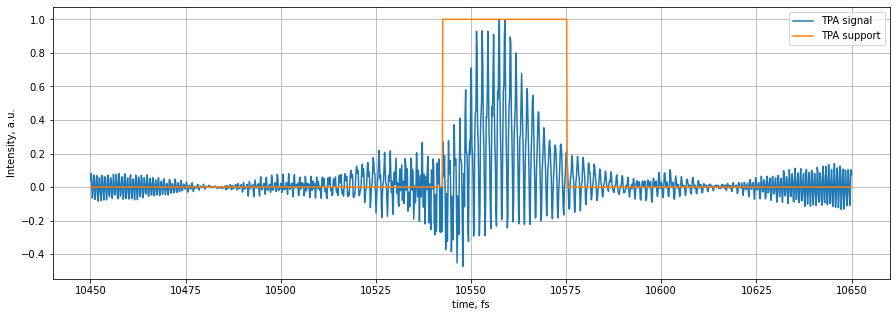

In [1005]:
tpa_freq = 3e8 / 440e-9
ifgm.get_g2_support(tpa_freq=tpa_freq, freq_window_size=3, tpa_thresh=0.2,
                               tpa_tolerance=1/tpa_freq, vmin=-550, vmax=550, plotting=True);

* Set ``` apply_support ``` parameter to True in the ```compute_g2``` method to set the g2 function values to 0 at delays outside of the support. 

* Use the same parameters as before. 
* g2 before application fo the support:

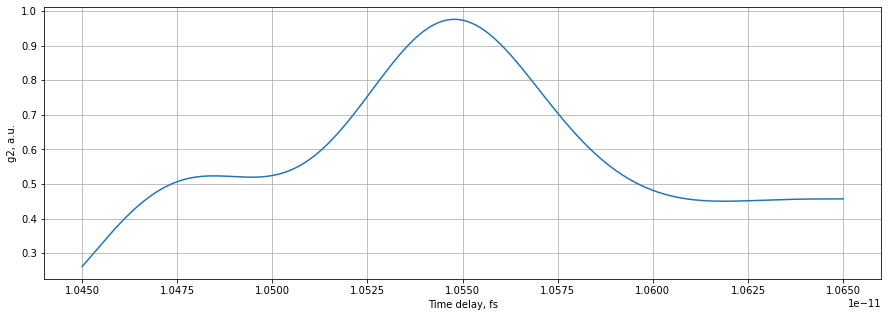

<Figure size 432x288 with 0 Axes>

In [1006]:
ifgm.compute_g2(filter_cutoff=15e12, filter_order=3, apply_support=False, plotting=True)

* g2 after the application of the support:

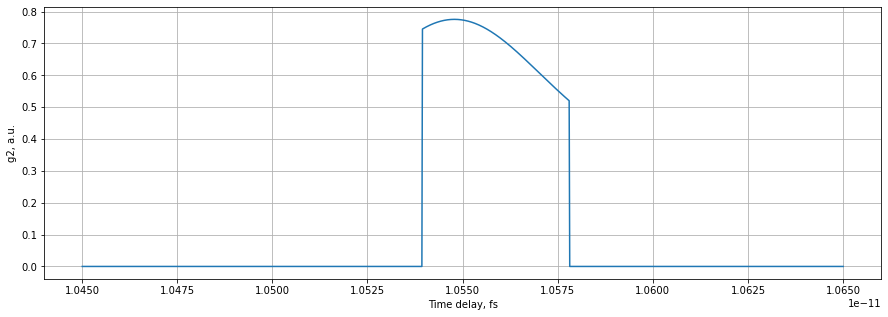

<Figure size 432x288 with 0 Axes>

In [980]:
ifgm.compute_g2(filter_cutoff=15e12, filter_order=3, apply_support=True, plotting=True)

### Calculation of the g2 upon Savitzky-Golay filtering of experimental data

* Zooming in to experimental interferograms, reveals the presence of noise (tiny spikes in between the major peaks in the Fig. below).

* This may potentially cause errors in calculation of the correlation function as it not only contributes to the inexistent high-frequency oscillations, but also  distorts the shape of the low-frequency components of the data (e.g. by making the pixel values too low or too high).  

* To de-noise, one could use e.g. Savitzky-Golay filter. The filter is optimal in the sense that it minimizes the least-squares error in fitting a polynomial to the samples of of noisy data. More info in [Savitzky_1964]


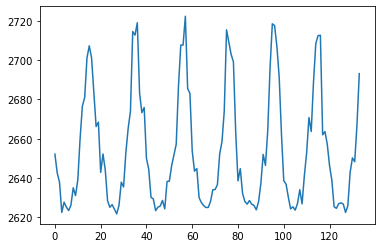

In [998]:
# interferogram before filtering
from matplotlib import pyplot as plt
plt.plot(ifgm.interferogram[600:-600])
plt.show()

* apply the filter by calling ```apply_savitzky_golay_filter```method on the class instance.

* set the filter's windows size either in pixels or relative to the Nyquist-Shannon's sampling rate (with 1 being the max possible window size as to not violate the sampling requirements)

* the filter order depends on the window size and hence has an upper bound

* **NOTE: application of the filter immediately re-writes the interferogram samples in the instance class (of course, they can be recovered back by initializing the class and reading out data)!**

In [999]:
# filter (the numbers shall be chosen empirically - think about the physics and the sampling requirements)
ifgm.apply_savitzky_golay_filter(window_size_shannon=1, window_size_pxls=None,  order=1)

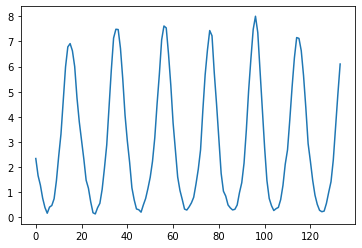

In [1008]:
# interferogram after filtering
from matplotlib import pyplot as plt
plt.plot(ifgm.interferogram[600:-600])
plt.show()

* Re-normalise interferogram upon the application of the filter  as the max and min amplitude values might have changed 

In [1009]:
ifgm.normalize_interferogram(normalizing_width=10e-15, t_norm_start=10450e-15)

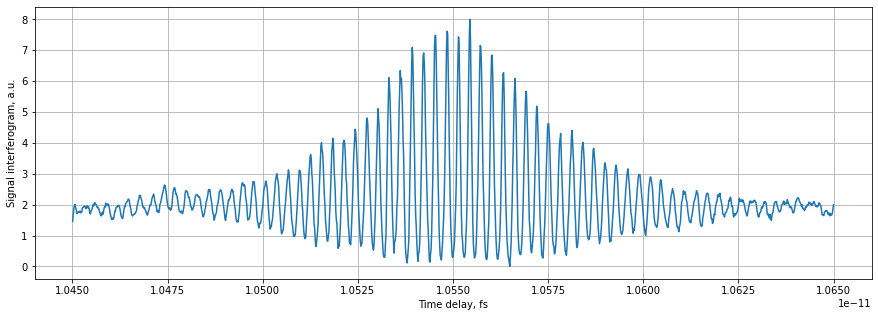

<Figure size 432x288 with 0 Axes>

In [1010]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="temporal", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

* Compute the g2 function again using the same method parameters, but this time using the filtered data.

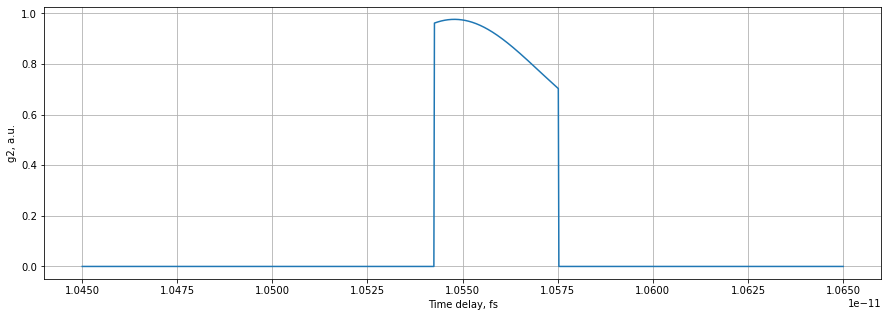

<Figure size 432x288 with 0 Axes>

In [1011]:
ifgm.compute_g2(filter_cutoff=15e12, filter_order=3, apply_support=True, plotting=True)

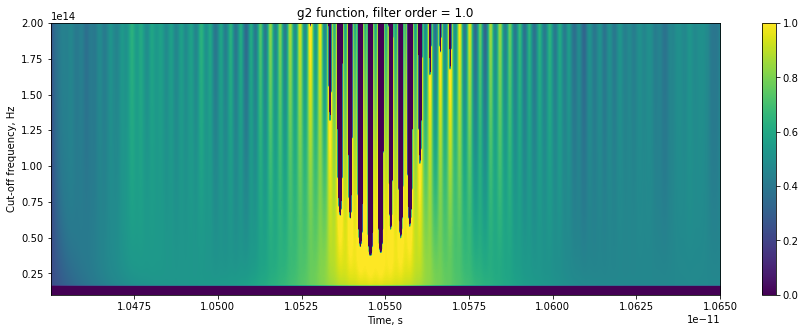

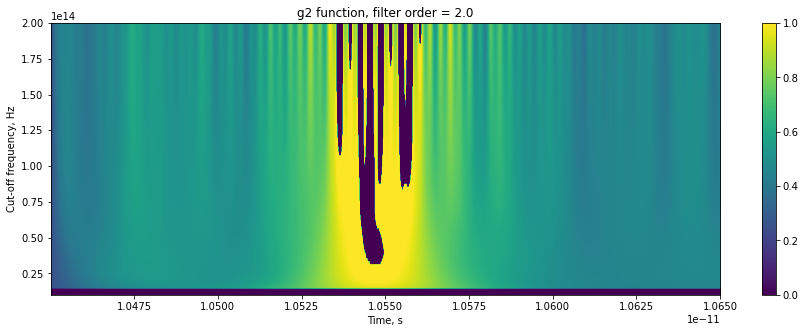

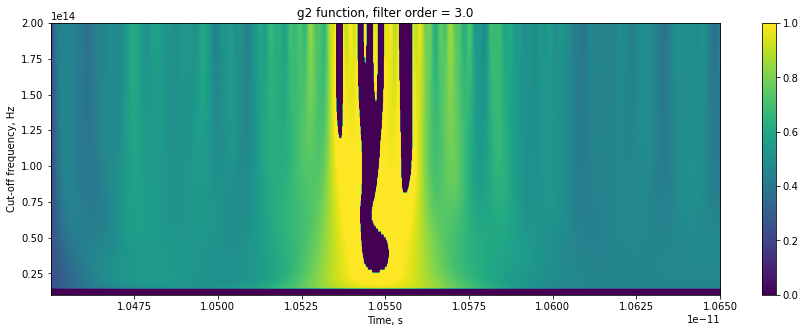

In [1013]:
ifgm.compute_g2_vs_lowpass_cutoff(cutoff_min = 10e12, cutoff_max = 200e12, cutoff_step = 2e12,
                              order_min = 1, order_max = 3, order_step = 1,
                              g2_min = 0.95, g2_max = 1.05,
                              to_plot = True);

* **This time the g2 function value is very close to 1 and there are no oscillations at different values of the delay!**

### How to find the width of the SG filter?

* The width of the SG filter window can be found empirically. One has to keep in in mind the physics of the process so that all relevant features are kept whilst being filtered.

* For example, it is good idea to keep the filter's window size below the Shannon's sampling rate to preserve all relevant features of the second harmonic (and hence of the interferometric autocorrelation). 

* To check how g2 function looks like to different window sizes, set ```keep_shannon_sampling=True```in the method ```gen_g2_vs_savitsky_golay```of the class instance.

* Example of g2 function for different window widths (keeps its values between 0.95 and 1.05 for a wide range) and fixed SG order=1

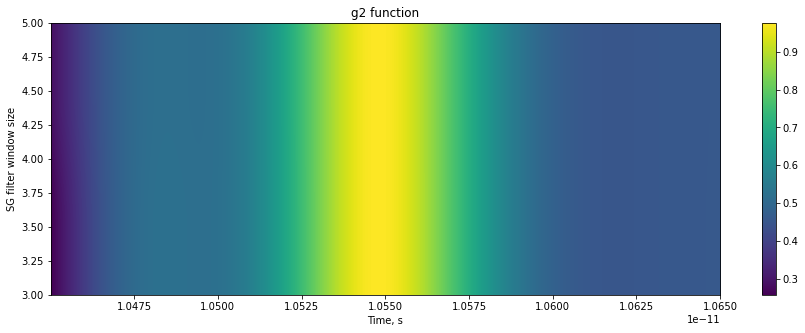

In [1021]:
ifgm.gen_g2_vs_savitsky_golay(sg_window_min=3, sg_window_max=201, sg_window_step=2,
                              keep_shannon_sampling=True,
                                 sg_order_min=1, sg_order_max=1, sg_order_step=1,
                                 bw_filter_order = 3, bw_filter_cutoff = 15e12,
                                 g2_min=0.95, g2_max=1.05,
                                 plotting=True);

## Display all data in any directory for quick visualisation of temporal and FT distributions

You can also display all data in any directory of interest. It is assumed though that **all data were recorded using the same units of time** (all datasets have units of e.g. fs)

* Initialize an instance of the class by providing the relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Set the unit of time used whilst recording the data
    * DO NOT set the ```filetoread``` and the ```time_step``` arguments - the code will find them out automatically whilst reading out the data sets.

* Read, analyse and display the dataset by calling the ```display_temporal_and_ft_batch()``` module on the instance of the initialized class.


base name 20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt.txt


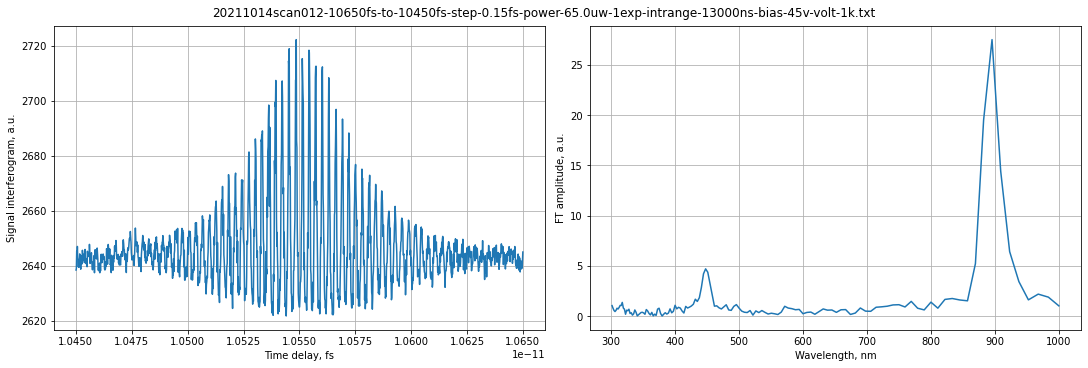

base name 20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt


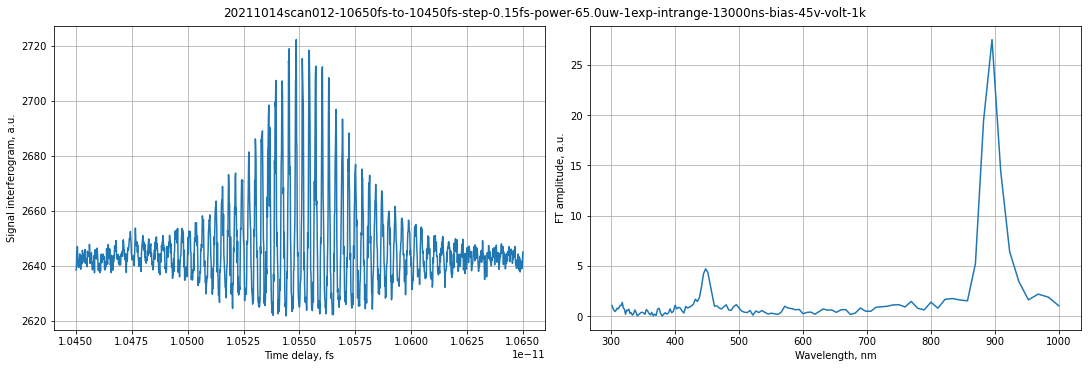

base name 20211014scan007-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-2600ns-bias-45v-volt-1k.txt


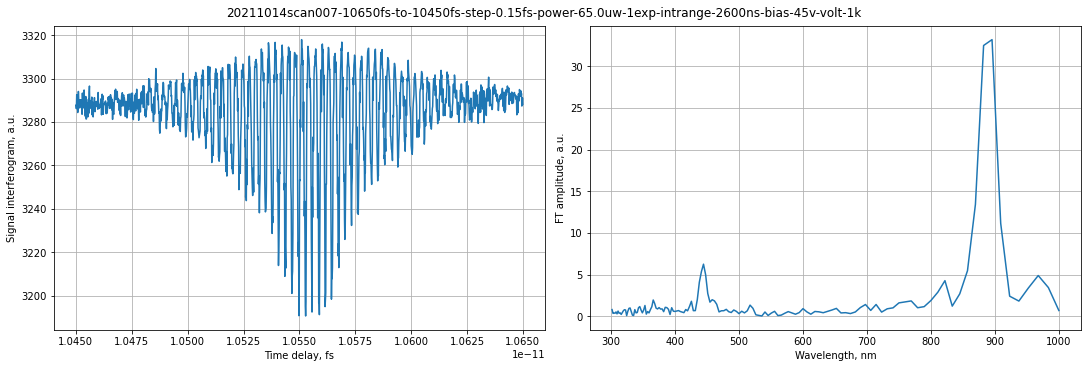

base name 20211014scan006-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-1300ns-bias-45v-volt-1k.txt


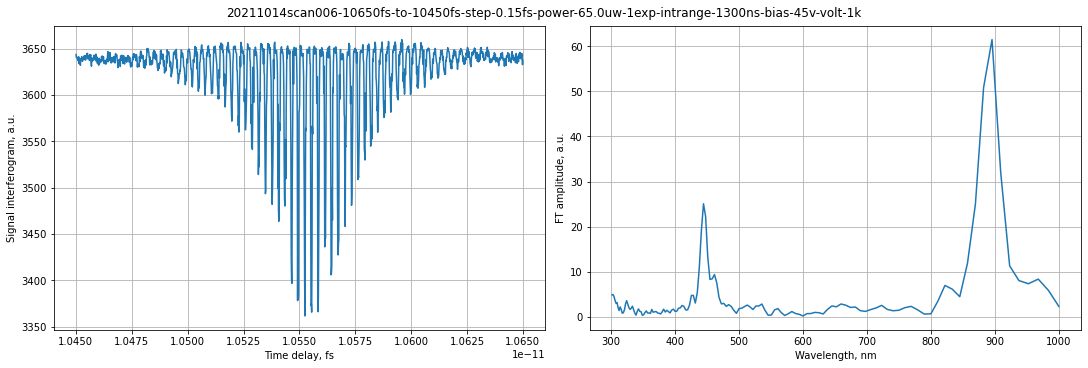

base name 20211014scan014-10650fs-to-10450fs-step-0.15fs-power-20.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt


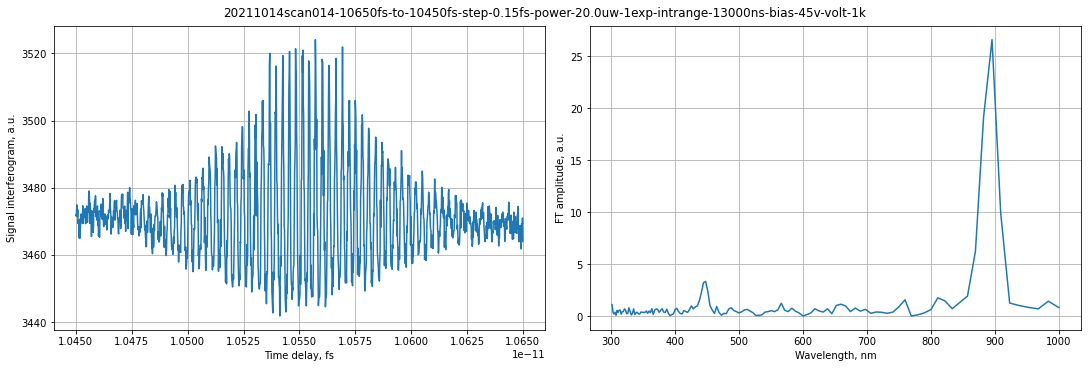

base name 20211014scan008-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-6500ns-bias-45v-volt-1k.txt


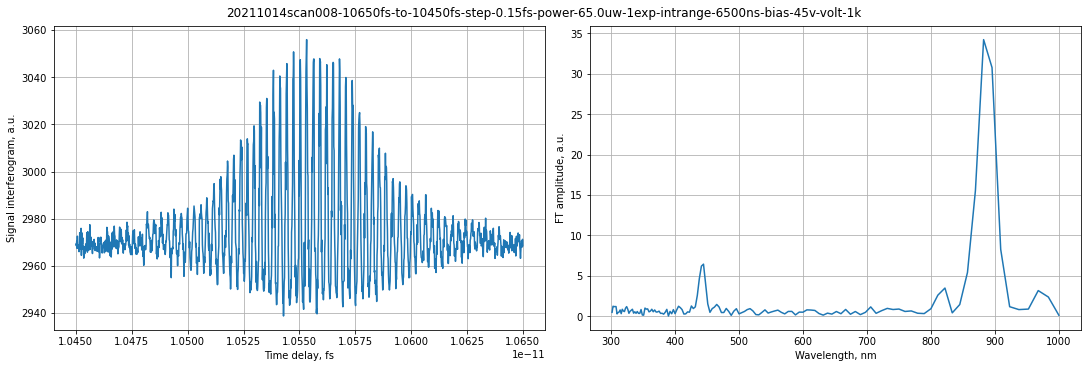

In [1025]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")

ifgm = Interferogram(pathtodata = datapath, tau_units = "fs")

ifgm.display_temporal_and_ft_batch(vs_wavelength=True, wav_min=300, wav_max=1000, wav_units="nm")

# Simulated interferograms 


* The following shows simulations of interferometric traces using ideal laser field distributions. 

### Interferometric autocorrelation trace, fixed parameters

* An interferometric autocorrelation distribution (here, simply referred to as an interferogram distribution) can be simulated by initialising an instance of the Simulation class.

* Set the parameters  such as sampling step, max and min values of the sampling interval, pulse duration, the wavelegnth of light, etc. More info in the docstring of the class.

In [32]:
from Interferometry.classes.simulation import Simulation

In [33]:
sim = Simulation(lambd0=880e-9, t_fwhm=50e-15, t_phase=0, 
                 t_start=-100e-15, t_end=100e-15, delta_t=0.15e-15,
                 tau_start=-100e-15, tau_end=100e-15, tau_step=0.15e-15)

* The interferogram is generated by calling ```gen_interferogram``` method on the initialised class instance.

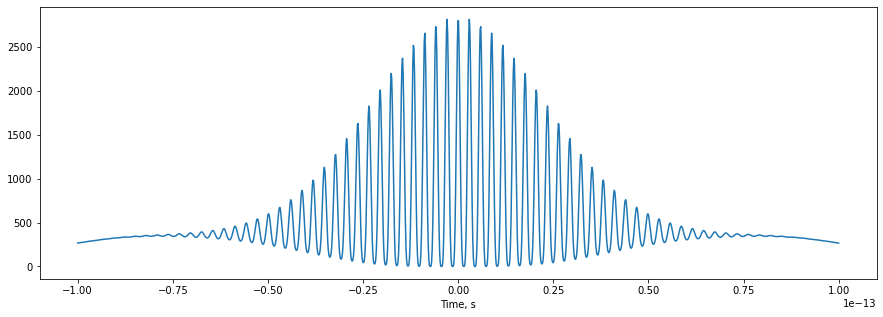

In [34]:
sim.gen_interferogram(temp_shift=0, plotting=True)

* Normalization could be done by calling ```normalize_interferogram_simulation``` method. The interferogram is normalized by the intensity distribution at one arm of the interferometer. 

* ```display_temporal_and_ft()```method called on the Simulation class instance displays the data

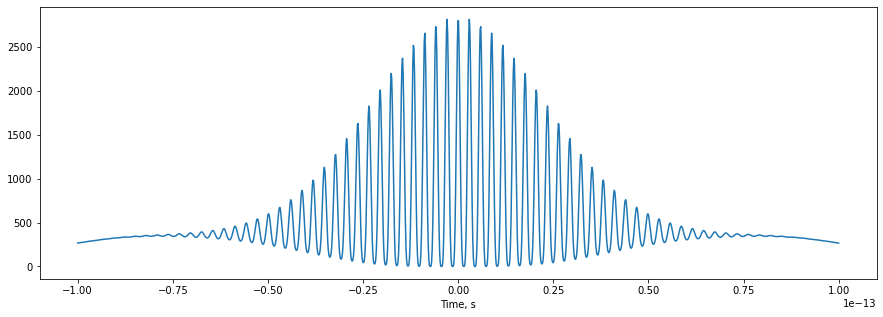

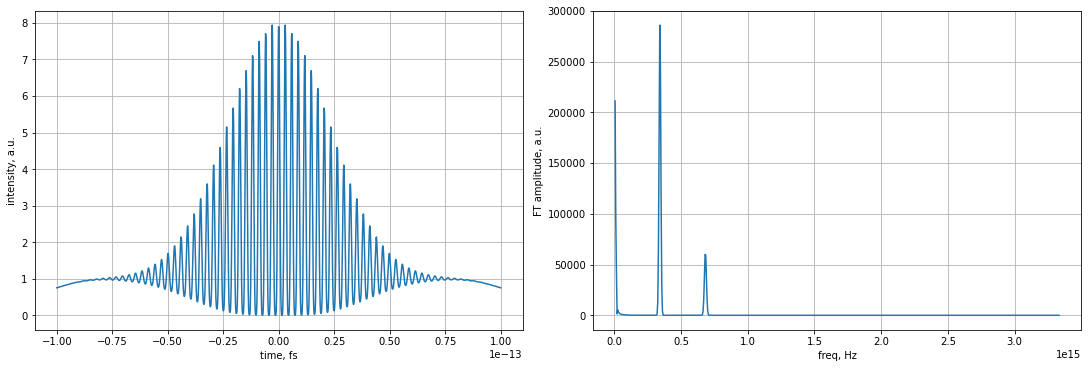

In [38]:
sim.gen_normalized_interferogram(temp_shift=0, plotting=True)
sim.display_temporal_and_ft()

* The ratio between the bottom part of the interferogram to its whole height is 1:8 as expected [Steinmeyer_1999], [ULP_Keller].

* If needed for visualisation purposes, the corresponding electric field profile can be generated by calling ```gen_e_field```method on he initialised class instance.

/Users/Pavel/anaconda3/envs/interferometry/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


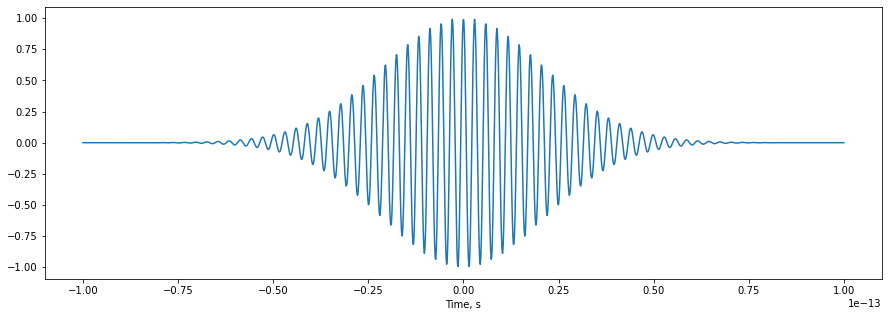

In [39]:
e_t, a_t = sim.gen_e_field(delay=0, plotting=True);

### Sum of interferometric and field autocorrelation traces, fixed parameters

* One could add a non-interferometric component (field autocorrelation) to the fully interferometric trace. 
* This can be done by setting the corresponding weights in the ```gen_complex_interferogram``` method


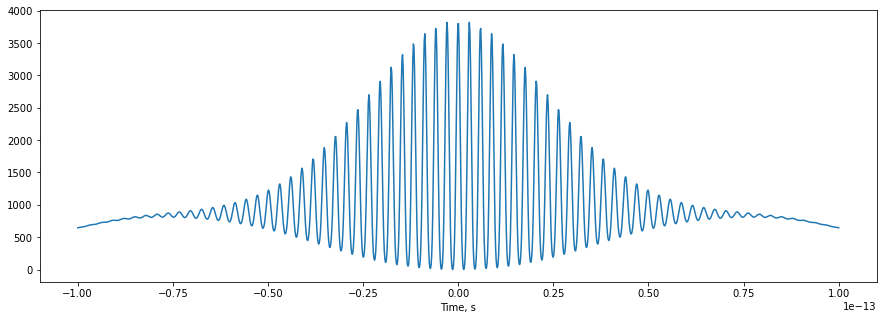

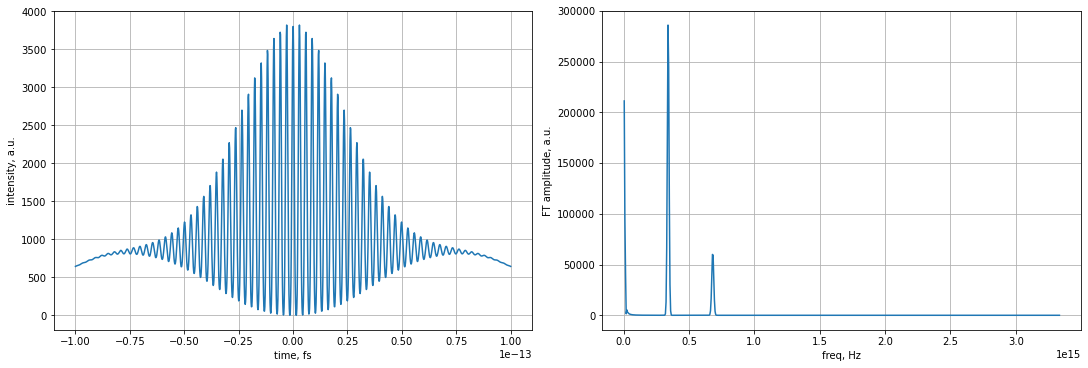

In [52]:
from matplotlib import pyplot as plt

sim.gen_complex_interferogram(field_ac_weight=1, interferometric_ac_weight=1, temp_shift=0, plotting=True)
sim.display_temporal_and_ft()
sim_data1 = sim.interferogram

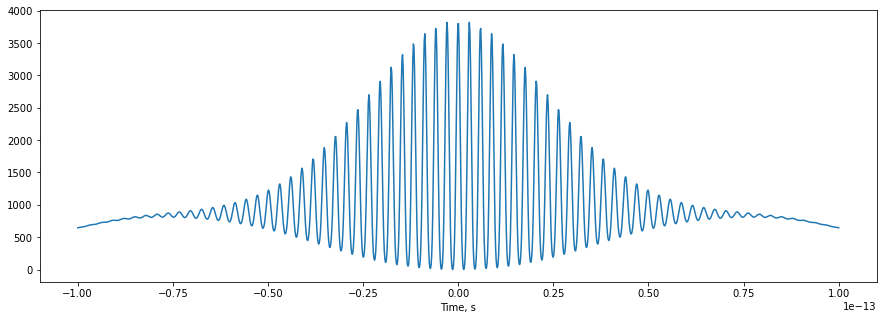

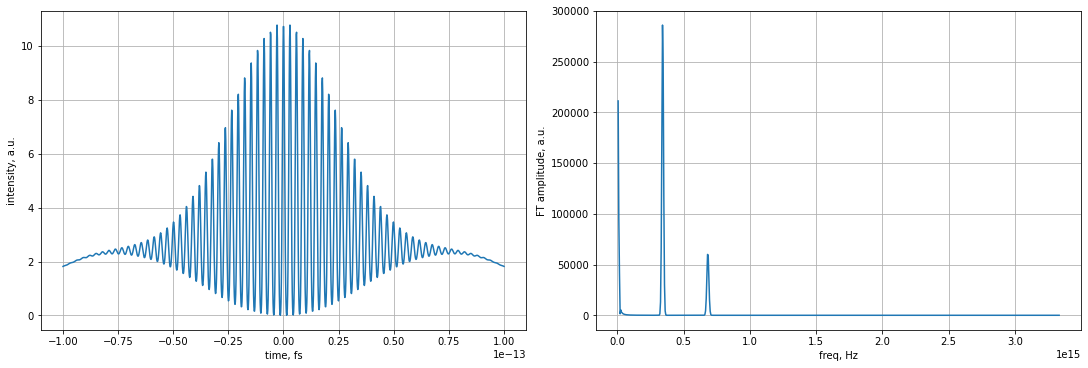

In [54]:
sim.gen_normalized_complex_interferogram(field_ac_weight=1, interferometric_ac_weight=1, 
                                         temp_shift=0, plotting=True)
sim.display_temporal_and_ft()


* The amount of field autocorelation changes the shape of the data so that the ratio between the bottom part of the interferogram to its whole height is no longer 1:8.

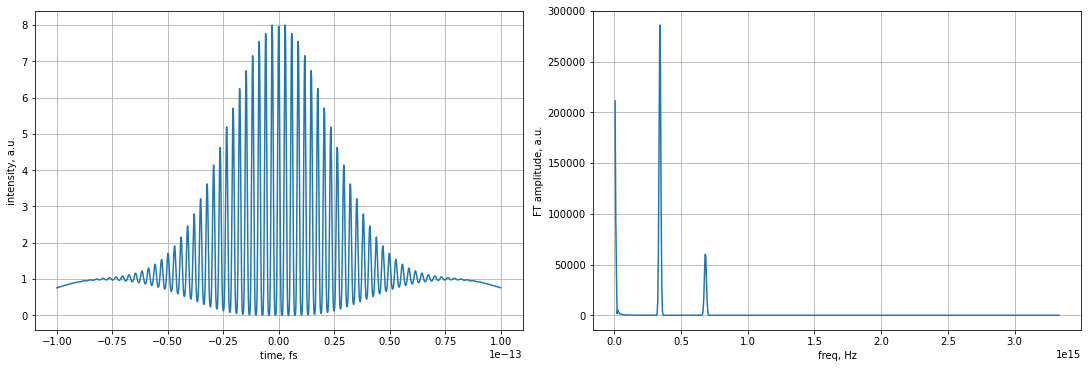

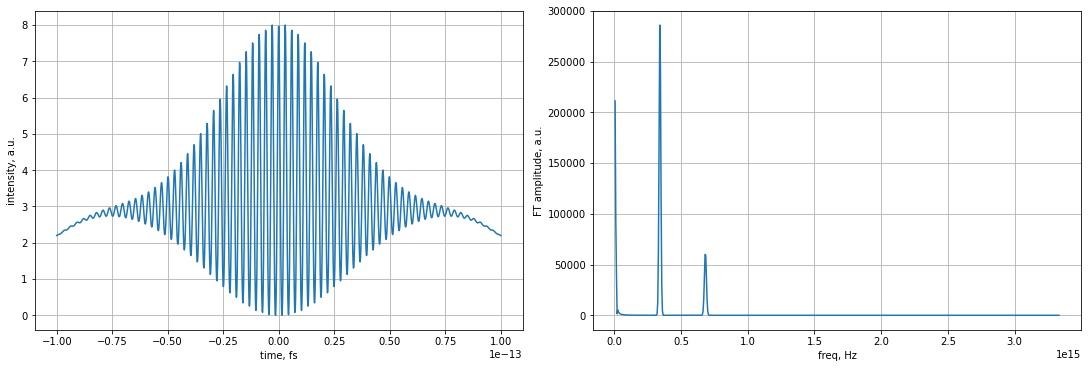

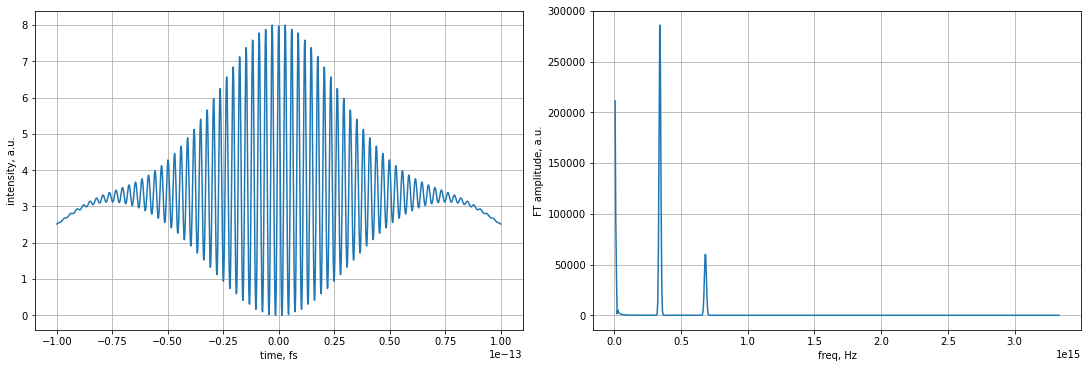

In [1049]:
for ii in range(0, 15, 5):
    sim.gen_complex_interferogram(field_ac_weight=ii, interferometric_ac_weight=1, temp_shift=0, plotting=False)
    sim.normalize_interferogram_simulation(normalizing_width=10e-15, t_norm_start=-1000e-15)
    sim.display_temporal_and_ft()

## Time-frequency analysis

* Normalize  an interferogram to have 1 to 8 ratio, just as we did for experimental data.

* Compute Wigner-Ville distribution. As expected, it has features of the 0th, 1st and 2nd harmonics. 

In [1090]:
sim.normalize_interferogram_simulation(normalizing_width=10e-15, t_norm_start=-4000e-15)

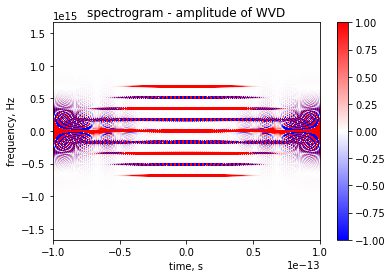

In [1091]:
sim.compute_wigner_ville_distribution(plotting=True, vmin=-1, vmax=1);

* In the previous section on experimental data processing, the question was how we can estimate the temporal range of the two-photon absorption in the experiment and hence the region where the values of the computed g2 function make physical sense (e.g. the so-called g2 function support).

* The method ```g2_support_simulated``` called on the Simulation class instance, estimates the g2 function support by  doing the following:

- extracts the TPA signal from the Wigner-Ville distribution of the measured interferogram;
- extract the intensity value of the TPA signal distribution at the set FWHM laser pulse duration (at -25 and 25 fs as the pulse length was set to 50 fs)

* For pulse duration in the range of interest (50-200 fs), the threshold is roughly the same and amounts to 20% of the maximum value of the TPA signal. 

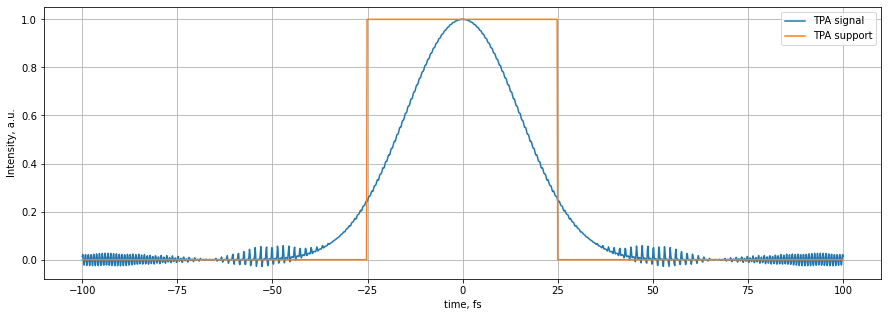

Threshold value of the WVD at TPA frequency is  0.24317508740688115


In [1093]:
sim.g2_support_simulated(tpa_freq=3e8 / 440e-9, freq_window_size = 3, vmin=-1, vmax=1,
                               plotting=True);

## Computation of the second-order correlation function  from simulated data

### Analytical computation

/Users/Pavel/Documents/repos/Interferometry/Interferometry/classes/simulation.py:347: ComplexWarning: Casting complex values to real discards the imaginary part
  self.g2_analytical[idx] = np.mean(e_t * np.conj(e_t) * e_t_tau * np.conj(e_t_tau) / np.mean((e_t * np.conj(e_t))**2))


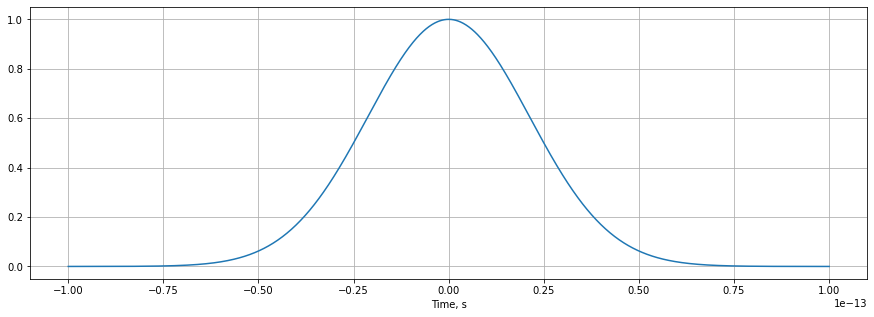

In [1095]:
g2 = sim.gen_g2_analytical(plotting=True)

* as expected, the g2 function value at delay 0 is equal to 1.

### By low-pass filtering 

* Compute  the g2 function by low-pass filtering the simulated interferogram. Provide a cutoff frequency and an order of the Butterworth filter to ```gen_g2``` method. 

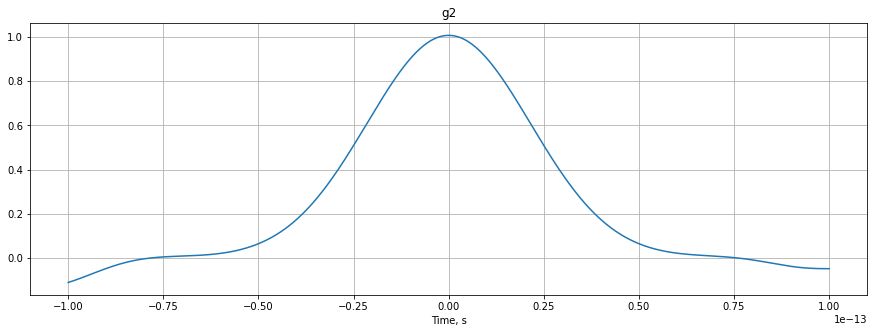

In [1099]:
sim.gen_g2(filter_cutoff=30e12, filter_order=3, plotting=True)

* To plot the distribution of the g2 function vs. different cut-off frequencies and for dofferent filter orders,
use the ```gen_g2_vs_cutoff_freq```method.
* For coherent light, at zero time delay the g2 function is expected to be 1.
* For illustration purposes, one may want to exclude from plotting those g2 functions
whose values at time delay zero are slightly above or below 1. 
* This can be done by setting g2_min and g2_max arguments.

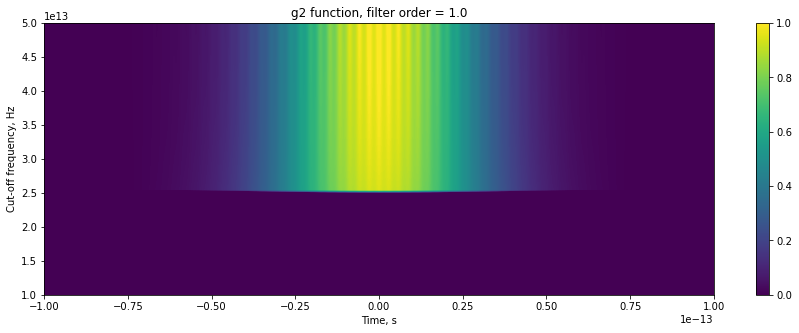

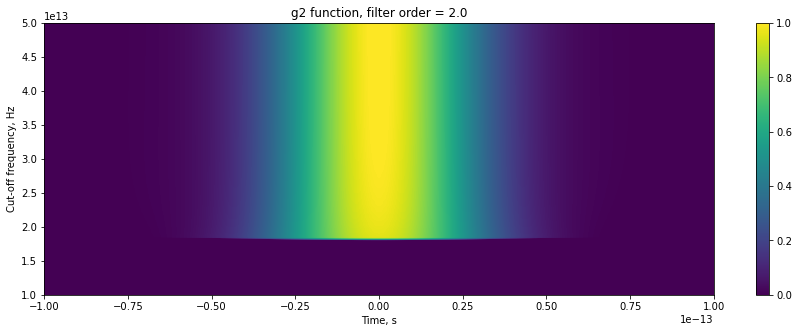

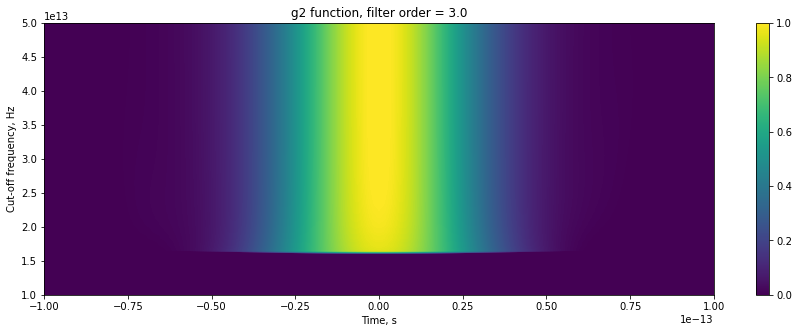

In [1101]:
sim.gen_g2_vs_cutoff(cutoff_min = 10e12, cutoff_max = 50e12, cutoff_step = 1e12,
                              order_min = 1, order_max = 3, order_step = 1,
                              g2_min = 0.95, g2_max = 1.05,
                              to_plot = True);

* Just as with experimental data, it is possible to obtain the g2 function by low-pass filtering the interferogram.

* The cut-off frequency range yielding g2 value of 1 at delay 0 is wider than in case of experimental data. 

* It depends on the filter order and on the data at hand as in the example below.

### Example: a mixture of interferometric and non-interferometric distributions


* Let us generate a weighted sum of interferometric and field autocorrelations and check  if  the value of the g2 function depends on the presence of the additional field a.c. term.


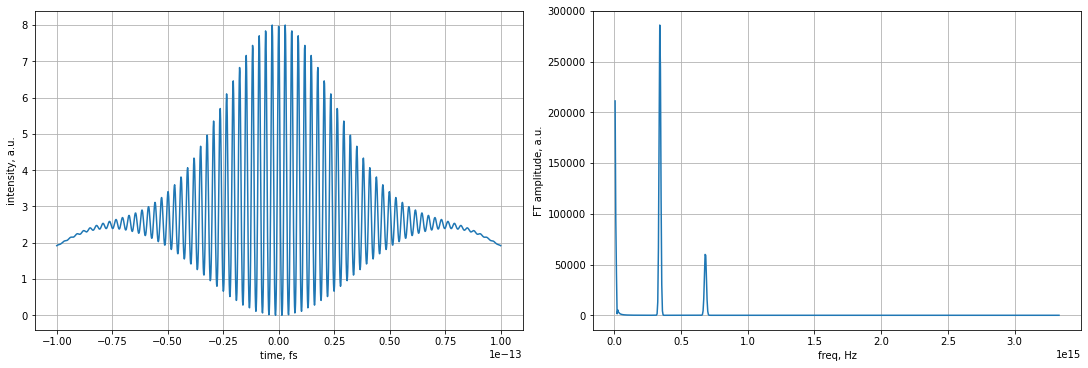

In [1102]:
sim.gen_complex_interferogram(field_ac_weight=3, interferometric_ac_weight=1, temp_shift=0, plotting=False)
sim.normalize_interferogram_simulation(normalizing_width=10e-15, t_norm_start=-1000e-15)
sim.display_temporal_and_ft()

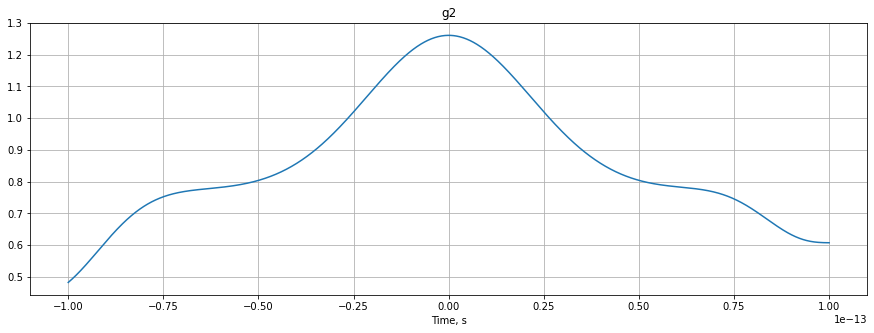

In [1103]:
sim.gen_g2(filter_cutoff=30e12, filter_order=3, plotting=True)

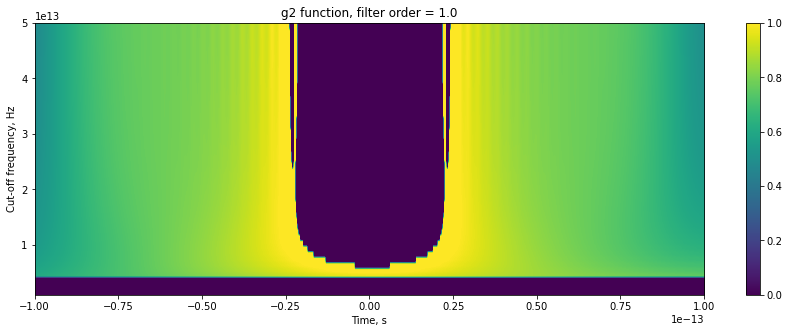

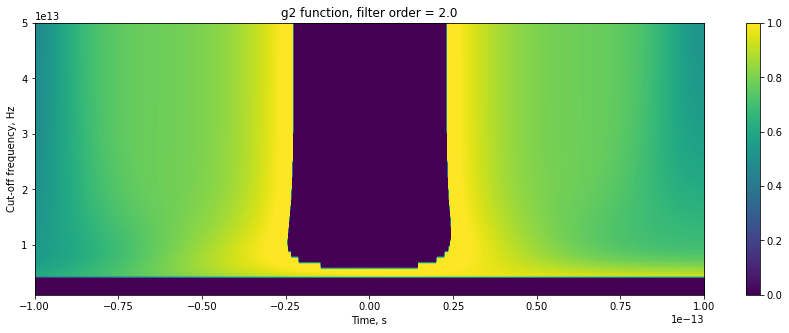

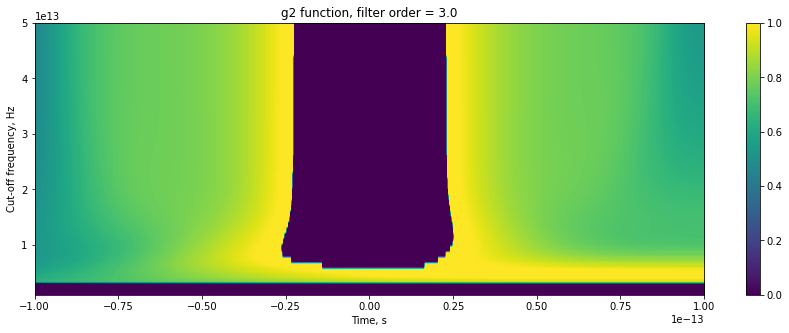

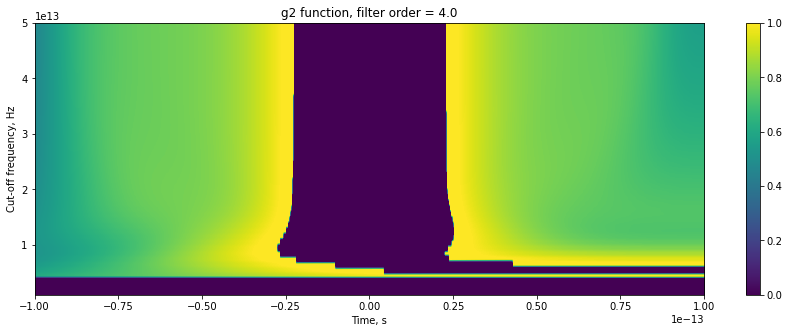

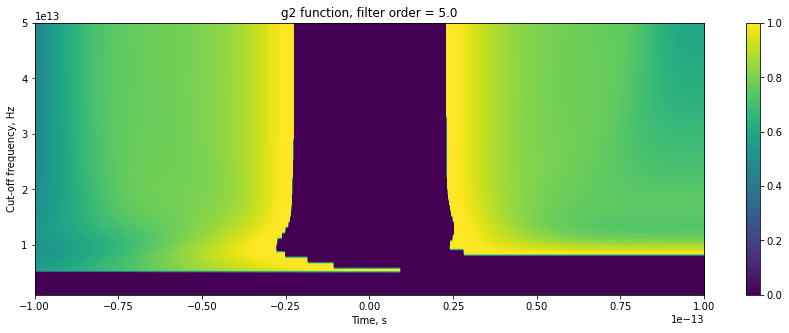

In [1106]:
sim.gen_g2_vs_cutoff(cutoff_min = 1e12, cutoff_max = 50e12, cutoff_step = 1e12,
                              order_min = 1, order_max = 5, order_step = 1,
                              g2_min = 0.95, g2_max = 1.05,
                              to_plot = True);

* The g2 function value heavily depends on the amount of a non-interferometric component present in the data!

* Given some fixed parameters of the low-pass filter, this leads to an increase of the g2 function value compared to that extracted from the purely interferometric data.

* The cut-off frequency cnahges as it is seen from the figs above.

* ### Hence, ideally, we need to extract the purely interferometric trace from experimental data and calculate the g2 function solely from this trace (as it is done in theory).  
 

# Literature

[Butterworth_1930](https://www.changpuak.ch/electronics/downloads/On_the_Theory_of_Filter_Amplifiers.pdf) Butterworth. On the theory of filter amplifiers, 1930. 

[Cohen_1999](http://people.ee.duke.edu/~lcarin/cohen.pdf) Cohen. Time-frequency distributions. A review. Proc. IEEE 77, 7, 1989

[Savitzky_1964](https://doi.org/10.1021%2Fac60214a047)  Savitzky and Golay. "Smoothing and Differentiation of Data by Simplified Least Squares Procedures". Analytical Chemistry. 36 (8): 1627–39, 1964

[Steinmeyer_1999](http://www.jstor.org/stable/2899810) Steinmeyer et al. Science, New Series, Vol. 286, No. 5444 (Nov. 19, 1999)

[ULP_Keller](https://ulp.ethz.ch/education/lectures/ultrafast-laser-physics/lecture-notes.html) Keller and Gallmann. Ultrafast Laser Physics, ETHZ, lecture notes.

